In [264]:
import os
import math
import glob
import itertools

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from typing import List, Optional, Union
import seaborn as sns

try:
    from nemo.utils import logging
except:
    import logging
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

## Setup/Config

In [279]:
base_metric_path = '../../data/benchmark_output/benchmark_data_rajesh'
metric_labels = ['nemo_random', 'nemo_ea2', 'nemo_20220713', 'nemo_20220714', 'nemo_20220720']
metric_paths = [os.path.join(base_metric_path, x) for x in metric_labels]

metric_paths = ['../../data/benchmark_output/CDDD', '../../data/benchmark_output/MegaMolBART/small_NeMo1.2_data_parallel'] + metric_paths
metric_labels = ['CDDD', 'NeMo1.2'] + metric_labels

acceptance_criteria = {'validity': 0.98, 'novelty': 0.50}

reports_dir = '/data/benchmark_output/nemo_20220714'
save_plots = False

## Load Data

In [280]:
def load_files(metric_paths: List[str], 
               metric_labels: Optional[List[str]] = None, 
               parse_timestamps: bool = False):
    """Load aggregated metric results from CSV files"""
    
    metric_labels = metric_labels if metric_labels else [None] * len(metric_paths)
    assert len(metric_labels) == len(metric_paths)
    custom_date_parser = lambda x: datetime.strptime(x, "%Y%m%d_%H%M%S")

    combined_metric_df = []
    for metric_path, metric_label in zip(metric_paths, metric_labels):
        file_list = glob.glob(os.path.join(metric_path, '**', '*.csv'), recursive=True)
            
        metric_df = []
        for file in file_list:
            kwargs = {'parse_dates':['timestamp'], 'date_parser':custom_date_parser} if parse_timestamps else {}
            df = pd.read_csv(file, **kwargs)
            
            exp_name = file.split('-')[-2] if not metric_label else metric_label
            df['exp_name'] = exp_name
            metric_df.append(df)

        metric_df = pd.concat(metric_df, axis=0).reset_index(drop=True)

        if parse_timestamps:
            metric_df['timestamp'] = metric_df['timestamp'].min()
            metric_df['timestamp'] = metric_df['timestamp'].dt.to_period('M') # Floor by month
        
        # Cleanup names -- need to regularize with team
        metric_df['name'] = metric_df['name'].str.replace('modelability-', '')
        physchem_mask = metric_df['name'].str.contains('physchem')
        metric_df.loc[physchem_mask, 'name'] = 'physchem'

        combined_metric_df.append(metric_df)
        
    return pd.concat(combined_metric_df, axis=0).reset_index(drop=True)

## Utilities

In [281]:
def set_plotting_style(show_grid: bool = False):
    sns.set_palette('dark')
    pal = sns.color_palette()
    sns.set_palette([pal[0]] + pal[2:])
    
    if show_grid:
        kwargs = {'axes.edgecolor': 'black', 'axes.linewidth': 1.5}
    else:
        kwargs = {'axes.grid' : False}
    sns.set_style("whitegrid", kwargs)
    
    
def _label_bars(ax: plt.Axes, max_value: Optional[float] = None):
    """Add value labels to all bars in a bar plot"""
    for p in ax.patches:
        value = p.get_height()

        if value < 0:
            va = 'top'
        else:
            va = 'bottom'

        if not math.isclose(value, 0.0):
            label = "{:.2f}".format(value)
            x, y = p.get_x() * 1.005, value * 1.005

            bbox = None
            if max_value:
                if y >= max_value:
                    bbox = dict(boxstyle="square", fc=(1.0, 1.0, 1.0), ec=(0.0, 0.0, 0.0))
                y = min(y, max_value)                
            ax.annotate(label, (x, y), va=va, bbox=bbox)
            
def setup_plots(num_plots: int, 
                plots_per_row: int, 
                xscale: int = 7, 
                yscale: int = 4):
    """Setup plotting axes"""

    rows = int(math.ceil(num_plots / plots_per_row))

    fig = plt.figure(figsize=(plots_per_row * xscale, (rows * yscale)), facecolor=(1.0, 1.0, 1.0))
    axes_list = fig.subplots(rows, plots_per_row)
    axes_list = axes_list.flatten()

    for ax in axes_list[num_plots:]:
        fig.delaxes(ax)

    return fig, axes_list

## Sampling Metrics

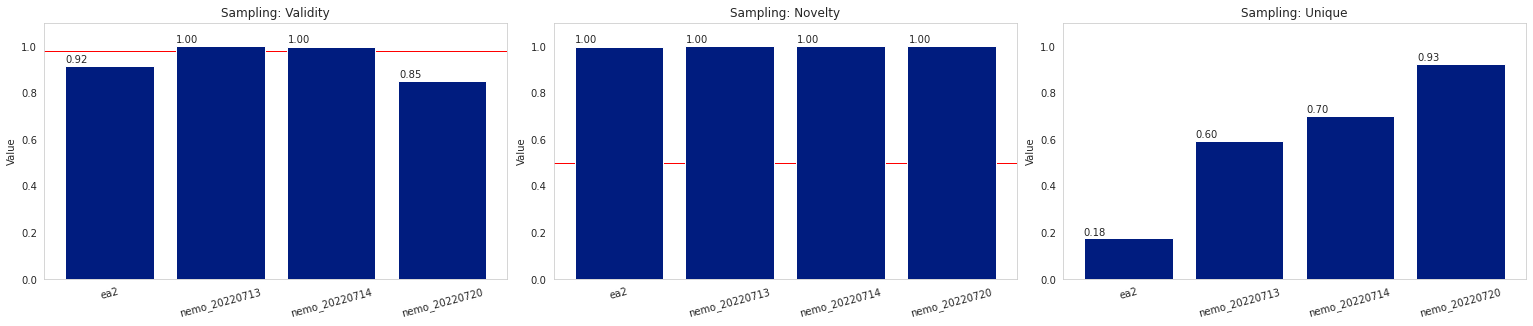

In [267]:
def make_multimodel_sampling_plots(df: pd.DataFrame, 
                                   acceptance_criteria: Optional[dict] = None,
                                   save_plots: bool = False, 
                                   reports_dir: Optional[str] = None):
    
    
    kpis = ['validity', 'novelty', 'unique']
    kpi_field = 'name'
    comparison_field = 'exp_name'
    value_field = 'value'
    
    # Get selected data
    query = f'{kpi_field} in {kpis}'
    df = df.query(query)[[kpi_field, comparison_field, value_field]]

    # Setup plots        
    set_plotting_style()
    num_plots = len(kpis)
    plots_per_row = 3
    fig, axes_list = setup_plots(num_plots, plots_per_row)
    

    for i, kpi in enumerate(kpis):
        query_str = f'{kpi_field} == "{kpi}"'
        plt_df = df.query(query_str)
        labels = plt_df[comparison_field]
        values = plt_df[value_field]
        
        ax = axes_list[i]
        
        if acceptance_criteria and acceptance_criteria.get(kpi, False):
            ax.axhline(y=acceptance_criteria[kpi], xmin=0, xmax=1, color='red', lw=1.0, zorder=-1)
            
        ax.bar(labels, values)
        ax.tick_params(axis='x', rotation=15)
        ax.set_ylim(0, 1.1)
        ax.set_title(f'Sampling: {kpi.title()}')
        ax.set_ylabel('Value')
        _label_bars(ax)
        
    fig.subplots_adjust(left=0.01,
                        bottom=0.01, 
                        right=0.99, 
                        top=0.90, 
                        wspace=0.1, 
                        hspace=0.2)
    if save_plots:
        save_path = os.path.join(reports_dir, 'Sampling_Aggregated_Benchmark.png')
        fig.savefig(save_path, dpi=300)


df = load_files(metric_paths=metric_paths, metric_labels=None, parse_timestamps=False)
make_multimodel_sampling_plots(df=df, acceptance_criteria=acceptance_criteria, save_plots=save_plots)

## Similarity Search

## Embedding Physchem

[NeMo I 2022-07-28 00:29:02 217758061:30] Dataframe for logD contains duplicate values. They will be averaged.


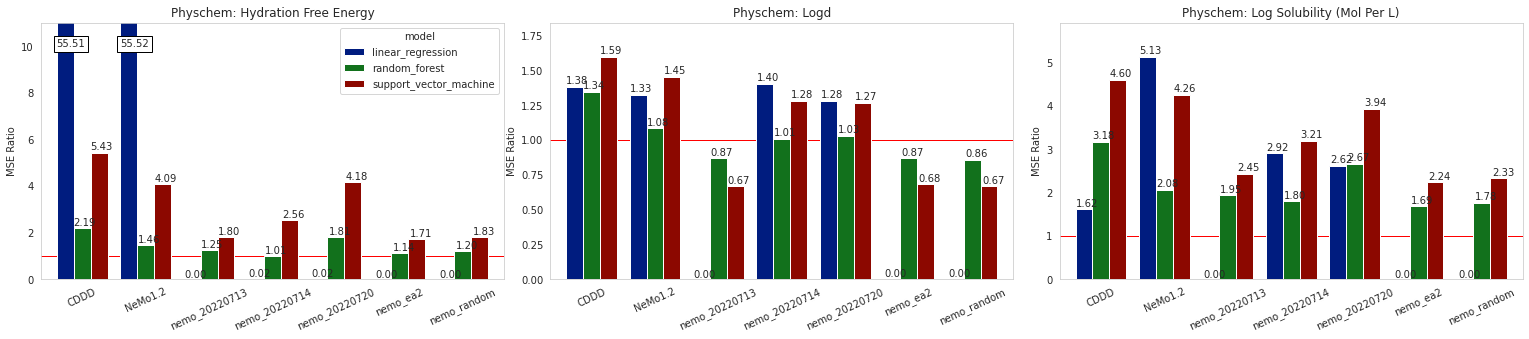

In [283]:
def make_multimodel_physchem_plots(df: pd.DataFrame, 
                                   save_plots: bool = False, 
                                   max_plot_ratio: float = 10.0,
                                   reports_dir: Optional[str] = None):
    
    # Get selected data
    kpis = ['physchem']
    models = ['linear_regression', 'support_vector_machine', 'random_forest']
    kpi_field = 'name'
    model_field = 'model'
    comparison_field = 'exp_name' # radius
    value_field = 'value'
    property_field = 'property'
    
    # Get selected data
    query = f'({kpi_field} in {kpis}) & ({model_field} in {models})'
    df = df.query(query)[[kpi_field, comparison_field, value_field, property_field, model_field]]

    # Setup plots
    set_plotting_style()
    num_plots = len(df[property_field].unique())
    plots_per_row = 3
    fig, axes_list = setup_plots(num_plots, plots_per_row)
    
    for i, (property_, plot_df) in enumerate(df.groupby(property_field)):        
        ax = axes_list[i]
        
        contains_duplicates = plot_df.groupby([model_field, comparison_field]).size().max() > 1
        if contains_duplicates:
            logging.info(f'Dataframe for {property_} contains duplicate values. They will be averaged.')
            
        plot_df = plot_df.pivot_table(columns=[model_field], values=value_field, index=comparison_field, aggfunc='mean')
        legend = True if i == 0 else False
        plot_df.plot(kind='bar', width=0.8, ax=ax, legend=legend)
        
        ax.axhline(1.0, 0, 1, color='red', lw=1.0, zorder=-1)
        property_title = property_.replace('_', ' ').title()
        
        ymin, ymax = ax.get_ylim()
        ymax = min(ymax, max_plot_ratio) * 1.1
        _label_bars(ax, 0.9 * ymax)
        
        ax.set_ylim(ymin, ymax)
        ax.tick_params(axis='x', rotation=25)
        ax.set_title(f'Physchem: {property_title}')
        ax.set_xlabel('')
        ax.set_ylabel(f'MSE Ratio')
        
        fig.subplots_adjust(left=0.01,
                    bottom=0.01, 
                    right=0.99, 
                    top=0.90, 
                    wspace=0.1, 
                    hspace=0.2)
    if save_plots:
        save_path = os.path.join(reports_dir, 'Physchem_Aggregated_Benchmark.png')
        fig.savefig(save_path, dpi=300)
        
    return

df = load_files(metric_paths=metric_paths, metric_labels=metric_labels, parse_timestamps=False)
make_multimodel_physchem_plots(df=df, save_plots=save_plots)

## Embedding Bioactivity

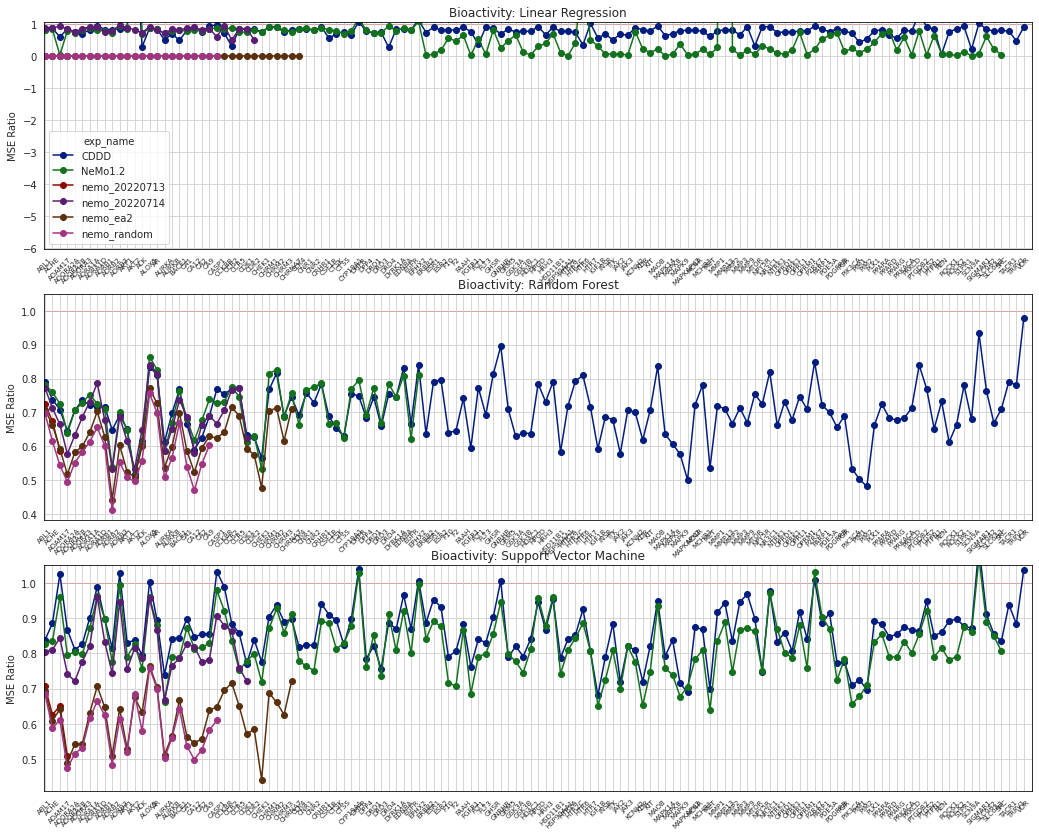

In [287]:
def make_multimodel_bioactivity_plots(df: pd.DataFrame, 
                                       save_plots: bool = False, 
                                       max_plot_ratio: float = 1.0,
                                       plot_type: str = 'line',
                                       reports_dir: Optional[str] = None):
    
    # Get selected data
    kpis = ['bioactivity']
    models = ['linear_regression', 'support_vector_machine', 'random_forest']
    kpi_field = 'name'
    model_field = 'model'
    comparison_field = 'exp_name' # radius
    value_field = 'value'
    property_field = 'gene'
    
    # Get selected data
    query = f'({kpi_field} in {kpis}) & ({model_field} in {models})'
    df = df.query(query)[[kpi_field, comparison_field, value_field, property_field, model_field]]
    gene_list = sorted(df[property_field].unique())
    n_genes = len(gene_list)

    # Setup plots
    set_plotting_style(show_grid=True)
    num_plots = 3
    plots_per_row = 1
    fig, axes_list = setup_plots(num_plots, plots_per_row, xscale=14)
    
    for i, (model_, plot_df) in enumerate(df.groupby(model_field)):
        ax = axes_list[i]
        
        contains_duplicates = plot_df.groupby([comparison_field, property_field]).size().max() > 1
        if contains_duplicates:
            logging.info(f'Dataframe for {model_} contains duplicate values. They will be averaged.')
        
        plot_df = plot_df.pivot_table(columns=[comparison_field], values=value_field, index=property_field, aggfunc='mean')
        legend = True if i == 0 else False
        kwargs = {'kind':'line', 'marker':'o'} if plot_type == 'line' else {'kind':'bar', width:0.8}
        plot_df.plot(ax=ax, legend=legend, **kwargs)
        
        ax.axhline(1.0, 0, 1, color='red', lw=1.0, zorder=-1)
        
        ymin, ymax = ax.get_ylim()
        ymax = min(ymax, max_plot_ratio) * 1.05
        _label_bars(ax, 0.9 * ymax)
        
        ax.set_ylim(ymin, ymax)
        ax.set_ylabel(f'MSE Ratio')
        
        ax.set_xlim(-0.1, n_genes + 0.1)
        ax.xaxis.set_tick_params(labelbottom=True)
        ax.set_xticks(range(0, n_genes))
        ax.set_xticklabels(gene_list, rotation=45, size='7')
        ax.set_xlabel('')
        
        model_title = model_.replace('_', ' ').title()
        ax.set_title(f'Bioactivity: {model_title}')
        
        fig.subplots_adjust(left=0.01,
                    bottom=0.01, 
                    right=0.99, 
                    top=0.90, 
                    wspace=0.1, 
                    hspace=0.2)
    if save_plots:
        save_path = os.path.join(reports_dir, 'Bioactivity_Aggregated_Benchmark.png')
        fig.savefig(save_path, dpi=300)
            
    return plot_df
            

df = load_files(metric_paths=metric_paths, metric_labels=metric_labels, parse_timestamps=False)
plot_df= make_multimodel_bioactivity_plots(df=df, save_plots=save_plots)